# 음성 인식 딥 러닝 모델 만들기(LSTM 사용)
https://commonvoice.mozilla.org/en/datasets
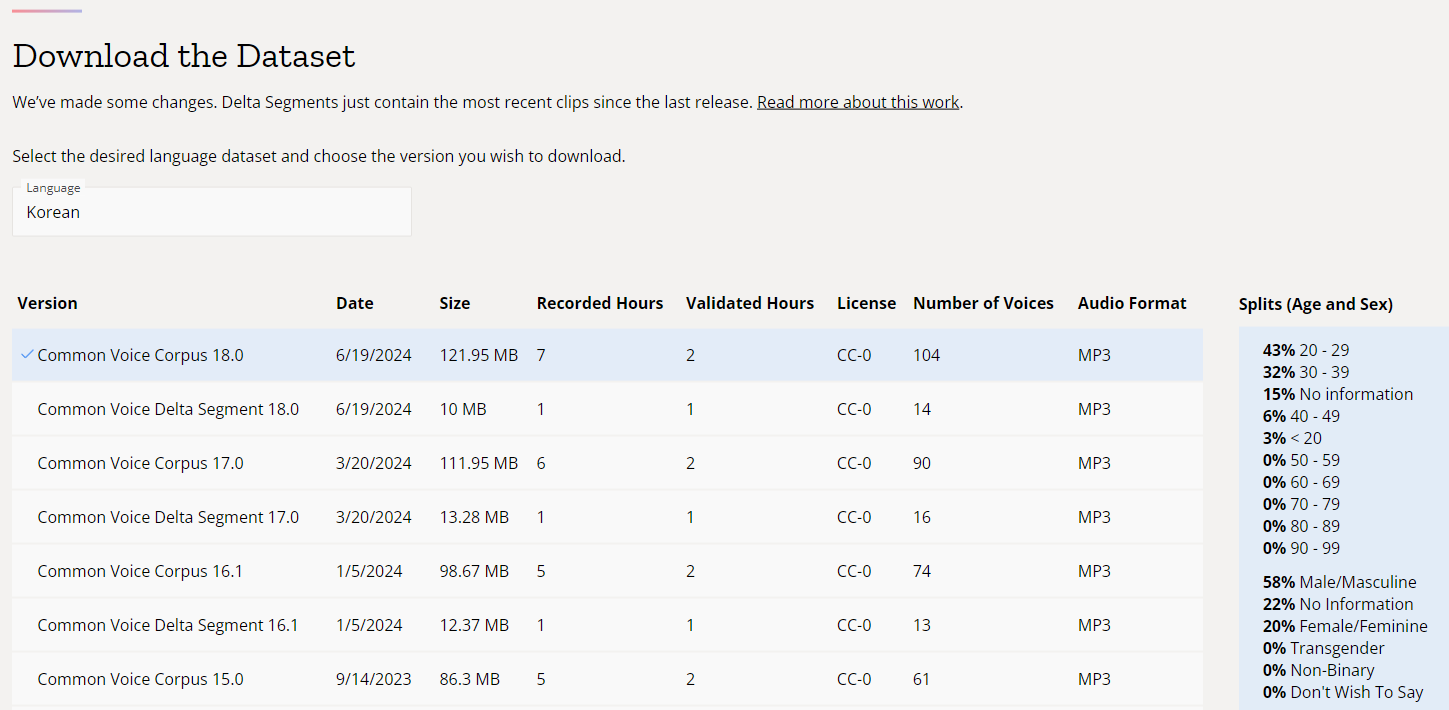

    Common Voice Corpus 18.0 이 데이터셋 사용
    
    실습 편의상 MP3파일을 WAV로 미리 변환한 파일 이용

In [1]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder

# 데이터셋 경로 설정
data_dir = "common-voice-corpus-18.0"
audio_dir = os.path.join(data_dir, "clips")
metadata_path = os.path.join(data_dir, "validated.tsv")

# 메타데이터 로드
metadata = pd.read_csv(metadata_path, sep='\t')

In [3]:
metadata.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,20018ecf222cd8726f3725dafffc6893736b7dc13833a5...,common_voice_ko_36838360.mp3,4b6b0cdf7775b48ff05757d180417439b96ecaee352963...,선비는 생각지 않은 이 말에 앞이 아뜩해지며 방 안이 핑핑 돌았다.,NaN,2,1,NaN,NaN,차분함,NaN,ko,NaN
1,832e171301367131ad9deffaab1d5a1002422b9f036972...,common_voice_ko_36800708.mp3,4f5f8d8db14f8b9bac399e38c0bcee32aba66d10448dcd...,민수는 지갑 속에서 돈을 내어 덕호 앞으로 밀어 놓았다.,NaN,2,0,NaN,NaN,사투리가 조금 있는,NaN,ko,NaN
2,83e9680975aea455accdfae2b9645d50dc3ef210f51e88...,common_voice_ko_39571266.mp3,8a6ed4dbb1e5432bad25aeeebf06d40021a4cca6af7b2e...,어리석은 자는 그 노를 다 드러내어도 지혜로운 자는 그 노를 억제하느니라,NaN,2,0,twenties,male_masculine,Seoul,NaN,ko,NaN
3,8d0e5063fd9b0bcd6cf669f154fe3b7c9ddb2553b22aed...,common_voice_ko_39610438.mp3,5e49e31236c066df4f0e8f1b1057b72de53750d27e8457...,애 점순아! 점순아!,NaN,4,0,twenties,male_masculine,non-native speaker,NaN,ko,NaN
4,ab6a7a282d97a74fe74002572de755a0242e6ff353a03e...,common_voice_ko_38697629.mp3,77ba3ee00cc1049b895c718f804b5203174c277e176105...,오 분 내로 끊어,NaN,2,0,NaN,NaN,NaN,NaN,ko,NaN


## 오디오 신호 처리 및 MFCC
    음성 인식 및 음성 분석에 유용한 특징을 추출할 수 있음
    
    오디오 신호 처리는 음성 인식, 음악 정보 검색 등 다양한 응용 분야에서 중요한 역할을 함
    멜 주파수 켑스트럼 계수(MFCC)는 오디오 신호의 특징을 추출하는 데 널리 사용되는 기법
    MFCC는 사람의 청각 시스템의 비선형 특성을 반영하여 음성 신호의 주파수 성분을 분석

 - MFCC 추출 과정
    1. 프레임 분할: 오디오 신호를 짧은 프레임으로 나눔
    2. 윈도우 함수 적용: 각 프레임에 윈도우 함수를 적용하여 신호의 경계 효과를 줄임
    3. FFT 적용: 각 프레임에 빠른 푸리에 변환(FFT)을 적용하여 주파수 스펙트럼을 얻음
    4. 멜 필터 뱅크 적용: 주파수 스펙트럼에 멜 필터 뱅크를 적용하여 멜 스펙트럼을 얻음
    5. 로그 스펙트럼 계산: 멜 스펙트럼의 로그를 계산
    6. DCT 적용: 로그 멜 스펙트럼에 이산 코사인 변환(DCT)을 적용하여 MFCC를 얻음

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 오디오 파일 경로
file_path = '녹음.wav'

# 오디오 파일 로드
y, sr = librosa.load(file_path, sr=None)
print(f"Audio signal: {y}") # 오디오 신호의 시간 도메인 샘플
print(f"Sample rate: {sr}") # 샘플링 레이트

Audio signal: [0. 0. 0. ... 0. 0. 0.]
Sample rate: 48000


In [5]:
# MFCC 추출
n_mfcc = 13
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) # n_mfcc는 추출할 MFCC의 수
print(f"Original MFCC shape: {mfccs.shape}")

Original MFCC shape: (13, 339)


## MFCC 추출 과정(librosa.feature.mfcc() 호출 시 내부에서 동작됨 참고만)

 1. **프레임 분할 (Framing)**
    - 오디오 신호는 시간 도메인에서 길기 때문에, 이를 짧은 프레임으로 나누어 처리
    - 일반적으로 20-40ms 길이의 프레임으로 분할
    
        frames = librosa.util.frame(y, frame_length=2048, hop_length=512)

 2. **윈도우 함수 적용 (Windowing)**
    - 각 프레임에 해밍 윈도우(Hamming window) 함수를 적용하여 프레임의 경계에서 발생하는 신호 왜곡을 줄임

        windowed_frames = frames * np.hamming(2048)

 4. **푸리에 변환 (FFT)**
    - 각 프레임에 대해 빠른 푸리에 변환(FFT)을 수행하여 시간 도메인 신호를 주파수 도메인 신호로 변환

        fft_frames = np.fft.rfft(windowed_frames, n=2048)

 4. **멜 필터 뱅크 적용 (Mel Filter Bank)**
    - 인간의 청각 인지 특성을 반영하기 위해 주파수 스펙트럼을 멜 스케일로 변환
    - 멜 필터 뱅크를 사용하여 스펙트럼을 멜 스펙트럼으로 변환

        mel_filters = librosa.filters.mel(sr, n_fft=2048, n_mels=40)
        mel_spectrogram = np.dot(mel_filters, np.abs(fft_frames)**2)

 5. **로그 스펙트럼 (Log Spectrum)**
    - 멜 스펙트럼의 값에 로그를 취하여 로그 멜 스펙트럼을 얻음
    - 인간의 청각 시스템이 소리 강도를 로그 스케일로 인지하는 것과 유사

        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)

 6. **이산 코사인 변환 (DCT)**
    - 로그 멜 스펙트럼에 대해 이산 코사인 변환(DCT)을 적용하여 최종적으로 MFCC를 추출
    - DCT는 주파수 영역에서 에너지를 집중시키는 역할을 함

        mfcc = scipy.fftpack.dct(log_mel_spectrogram, type=2, axis=0, norm='ortho')[:13]

In [6]:
# MFCC 패딩 또는 크롭
# 추출된 MFCC의 길이가 max_len보다 작으면 0으로 패딩하고, max_len보다 크면 max_len까지 크롭
max_len = 100

if mfccs.shape[1] < max_len:
    mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
else:
    mfccs = mfccs[:, :max_len]

print(f"Padded/Cropped MFCC shape: {mfccs.shape}")

Padded/Cropped MFCC shape: (13, 100)


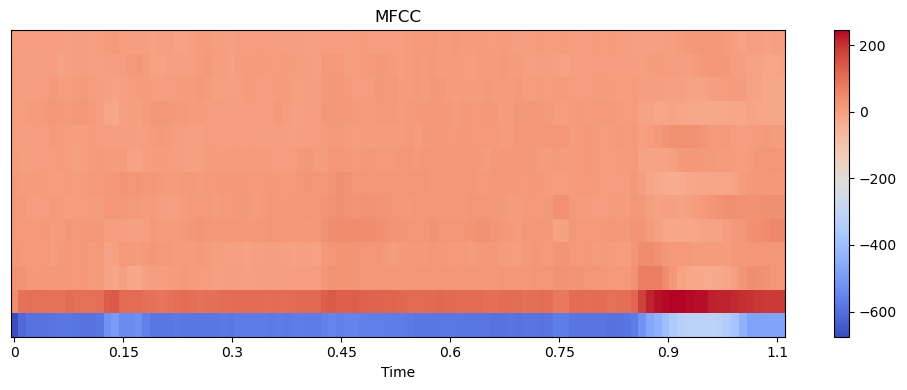

In [7]:
# MFCC 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar() # MFCC 값의 크기 표시를 위한 컬러바 추가
plt.title('MFCC')
plt.tight_layout()
plt.show()

#### MFCC 시각화 해석
     오디오 신호의 시간-주파수 정보를 나타냄
     x축은 시간
     y축은 MFCC 계수
     색상은 각 계수의 크기를 나타내며, 밝을수록 값이 크다는 것을 의미

     - 시간-주파수 정보
         시각화된 MFCC는 시간에 따라 주파수 특징이 어떻게 변하는지를 보여줌
     - 음성 인식
         특정 패턴이나 특징을 통해 음성 인식 시스템이 발음을 구별할 수 있게 함

MFCC를 추출하여 시각화함으로써 오디오 신호의 주요 주파수 특징을 이해하는 데 도움을 줌

Audio signal: [0. 0. 0. ... 0. 0. 0.]
Sample rate: 48000
Original MFCC shape: (13, 339)
Padded/Cropped MFCC shape: (13, 100)


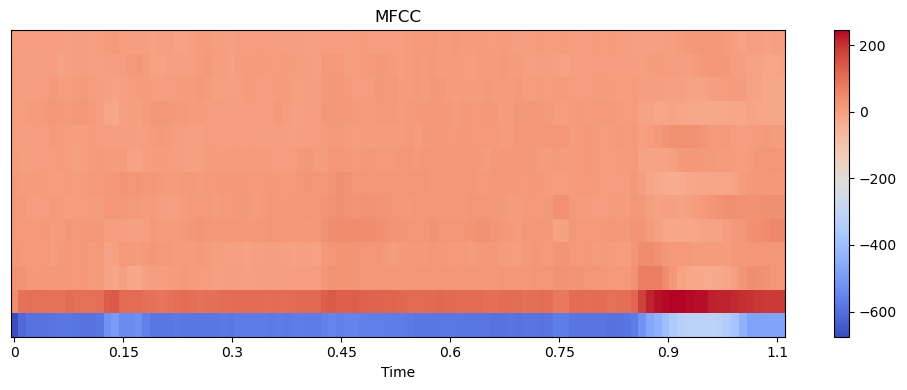

In [8]:
# 전체 코드
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 오디오 파일 경로
file_path = '녹음.wav'
n_mfcc = 13
max_len = 100

# 오디오 파일 로드
y, sr = librosa.load(file_path, sr=None)
print(f"Audio signal: {y}\nSample rate: {sr}")

# MFCC 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
print(f"Original MFCC shape: {mfccs.shape}")

# MFCC 패딩 또는 크롭
if mfccs.shape[1] < max_len:
    mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
else:
    mfccs = mfccs[:, :max_len]

print(f"Padded/Cropped MFCC shape: {mfccs.shape}")

# MFCC 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [9]:
# mfcc를 추출하는 기능을 오디오 신호에서 특성 추출을 하는 함수로 정의
def extract_features(file_path, n_mfcc=13, max_len=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfccs.shape[1] < max_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    return mfccs

In [10]:
# 특성 및 라벨 추출
features = []
labels = []

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['path']) # 오디오 파일의 경로 생성
    mfccs = extract_features(file_path) # 오디오 파일에서 MFCC 특성 추출
    features.append(mfccs) # 추출된 오디오 특성 저장
    labels.append(row['sentence']) # 오디오 특성에 맞는 텍스트 레이블 저장

features = np.array(features) # 리스트를 넘파이 배열로 변환
labels = np.array(labels) # 리스트를 넘파이 배열로 변환


In [11]:
features.shape, labels.shape

((1152, 13, 100), (1152,))

In [12]:
features[0], labels[0]

(array([[-6.21430725e+02, -6.21430725e+02, -5.94457397e+02, ...,
         -5.10360535e+02, -5.16749939e+02, -5.07119507e+02],
        [ 0.00000000e+00,  0.00000000e+00,  3.57160187e+01, ...,
          1.18717812e+02,  1.03667046e+02,  8.95621262e+01],
        [ 0.00000000e+00,  0.00000000e+00,  2.90484962e+01, ...,
          5.26242523e+01,  3.97461929e+01,  2.10905781e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00, -9.42470455e+00, ...,
         -1.00092049e+01, -5.95110989e+00, -4.22551537e+00],
        [ 0.00000000e+00,  0.00000000e+00, -6.26845074e+00, ...,
          3.29906797e+00, -4.63240325e-01, -4.72816467e+00],
        [ 0.00000000e+00,  0.00000000e+00, -3.38555384e+00, ...,
          8.61105919e+00, -1.64071679e+00, -6.06650448e+00]], dtype=float32),
 '선비는 생각지 않은 이 말에 앞이 아뜩해지며 방 안이 핑핑 돌았다.')

In [13]:
# 라벨 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y[0:10]

array([ 638,  558,  759,  741,  831,  397, 1011,  981,  378,  502],
      dtype=int64)

In [14]:
y.shape

(1152,)

In [15]:
# 원핫 인코딩
y = tf.keras.utils.to_categorical(y)

In [16]:
y.shape

(1152, 1151)

In [17]:
indexes = np.argmax(y, axis=1)
indexes

array([638, 558, 759, ..., 331, 500, 934], dtype=int64)

In [18]:
# 데이터셋 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

### 음성인식 모델 훈련하기(LSTM)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking, Input

# LSTM 모델 정의
model = Sequential([
    Input(shape=(features.shape[1], features.shape[2])),
    Masking(mask_value=0.),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.0000e+00 - loss: 7.0558 - val_accuracy: 0.0000e+00 - val_loss: 7.0481
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.0564 - loss: 6.9385 - val_accuracy: 0.0000e+00 - val_loss: 7.2527
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2102 - loss: 6.6240 - val_accuracy: 0.0000e+00 - val_loss: 7.8783
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.2491 - loss: 6.0141 - val_accuracy: 0.0000e+00 - val_loss: 8.7032
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5975 - loss: 5.3320 - val_accuracy: 0.0000e+00 - val_loss: 9.2886
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8423 - loss: 4.7112 - val_accuracy: 0.0000e+00 - val_loss: 9.5612
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9375 - loss: 4.0951 - val_accuracy: 0.0000e+00 - val_loss: 9.8963
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9923 - loss:

### 설명
**Sequential 모델:** 레이어를 순차적으로 쌓아 올리는 방식으로 모델을 정의

**Input 레이어:** 입력 데이터의 형태를 지정
        features.shape[1]은 타임스텝의 수
        features.shape[2]는 각 타임스텝의 특징 수
    
**Masking 레이어:** 입력 시퀀스에서 패딩된 값(여기서는 0)을 무시(시퀀스의 유효한 부분만 처리)
 
**첫 번째 LSTM 레이어:** 128개의 LSTM 유닛을 가진 첫 번째 LSTM 레이어
        return_sequences=True로 설정하여 모든 타임스텝에 대한 출력을 다음 레이어에 전달
    
**두 번째 LSTM 레이어:** 128개의 LSTM 유닛을 가진 두 번째 LSTM 레이어
        기본적으로 마지막 타임스텝의 출력만 반환
    
**Dense 레이어:** 출력 레이어
        클래스의 수 (y.shape[1])만큼의 뉴런을 가지며, softmax 활성화 함수를 사용하여 클래스 확률을 반환



#### 예측을 위한 새로운 파일에 대해서도 학습 때와 동일하게 전처리를 적용하여 예측 수행

In [20]:
# 새로운 오디오 파일 예측
def predict(file_path):
    mfccs = extract_features(file_path)
    mfccs = np.expand_dims(mfccs, axis=0)
    prediction = model.predict(mfccs)
    predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))
    return predicted_label

# 예측 예시
new_file_path = "common_voice_ko_38203273.mp3"
predicted_label = predict(new_file_path)
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: ['안녕히 다녀옵시요.']


#### 결과

    엉뚱한 문장으로 예측함  
    부족한 부분이 있는 것으로 보임

#### 직접 녹음한 파일 활용
    Windows 녹음기를 사용하여 자신의 목소리를 녹음한다.
    녹음할 문장은 학습에 사용한 문장을 이용한다.
    문장: 완전 예쁘십니다~

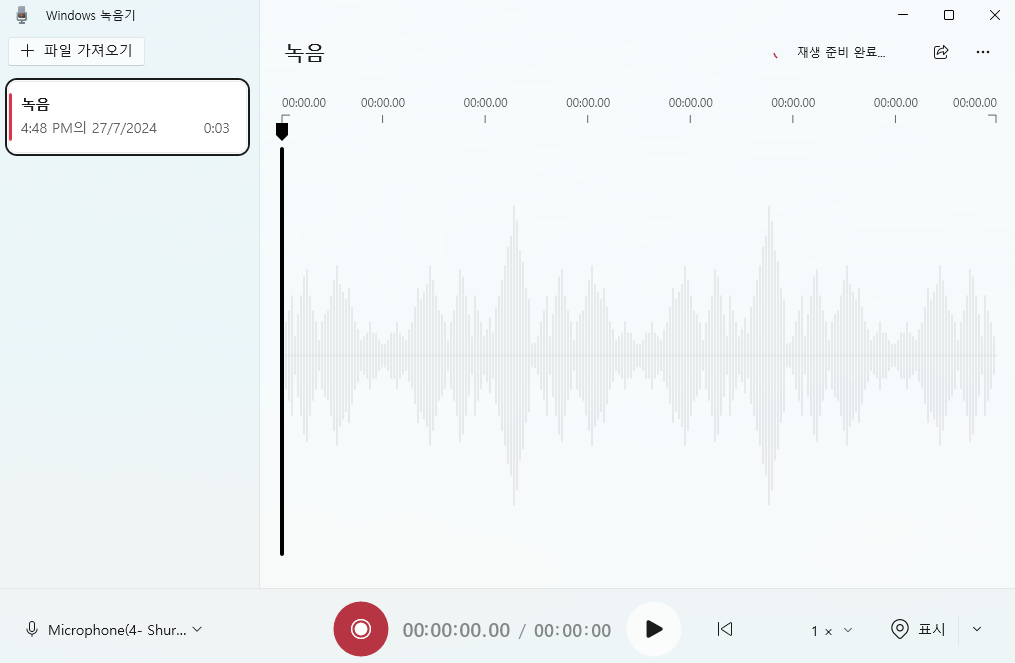

    m4a확장자로 저장되는데 이를 mp3파일로 변환해서 사용

In [21]:
#!pip install pydub

#### 다음 파일 변환 함수에서 파일을 못 찾을 경우

    - 파일 경로 확인 시 문제 없는 경우 FFmpeg 설치 필요
    - 설치 후 주피터 노트북 재시작

#### FFmpeg 설치 방법
FFmpeg 다운로드 및 설치  

    https://github.com/BtbN/FFmpeg-Builds/releases
    다운로드한 압축 파일을 원하는 디렉토리에 압축 해제

환경 변수 설정 (Windows)
    
    FFmpeg 바이너리(bin)가 있는 디렉토리를 시스템 환경 변수 PATH에 추가
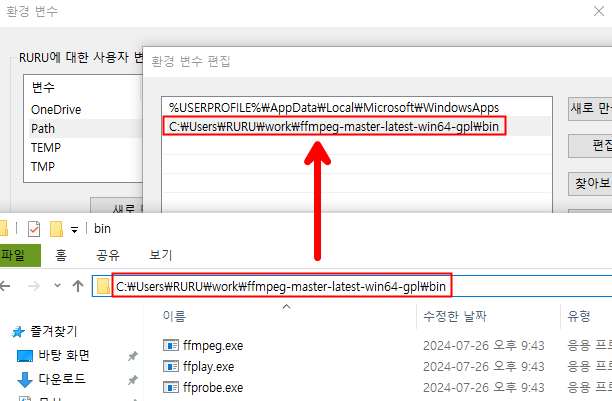
       
환경 변수 설정 확인

    명령 프롬프트를 열고 ffmpeg 명령어를 입력하여 FFmpeg가 제대로 설치되었는지 확인
    FFmpeg 버전 정보가 출력되면 설치가 제대로 된 것
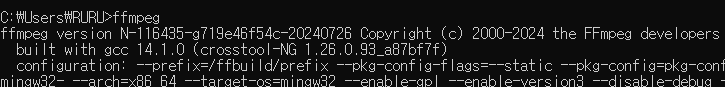


In [22]:
from pydub import AudioSegment

def convert_m4a_to_mp3(m4a_file_path, mp3_file_path):
    print(m4a_file_path)
    # m4a 파일을 AudioSegment로 로드
    audio = AudioSegment.from_file(m4a_file_path, format="m4a")
    # wav 파일로 변환 및 저장
    audio.export(mp3_file_path, format="mp3")

# 예시 사용
m4a_file_path = "녹음.m4a"
mp3_file_path = "녹음.mp3"
convert_m4a_to_mp3(m4a_file_path, mp3_file_path)

녹음.m4a


In [23]:
# 예측 예시
new_file_path = "녹음.mp3"
print(f"Predicted Label: {predict(new_file_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Label: ['신철이는 어정어정 걸으며 어젯저녁에 밤송이 동무에게서 얻어 두었던 신문을 포켓에서 꺼내 들었다.']


#### 하이퍼파라미터 튜닝

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking, Input

# LSTM 모델 정의
model2 = Sequential([
    Input(shape=(features.shape[1], features.shape[2])),
    Masking(mask_value=0.),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(y.shape[1], activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model2.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.0023 - loss: 7.0573 - val_accuracy: 0.0000e+00 - val_loss: 7.0503
Epoch 2/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.0681 - loss: 6.9336 - val_accuracy: 0.0000e+00 - val_loss: 7.2790
Epoch 3/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2398 - loss: 6.6244 - val_accuracy: 0.0000e+00 - val_loss: 8.0289
Epoch 4/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.2898 - loss: 5.9807 - val_accuracy: 0.0000e+00 - val_loss: 8.8985
Epoch 5/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5728 - loss: 5.3568 - val_accuracy: 0.0000e+00 - val_loss: 9.3554
Epoch 6/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8330 - loss: 4.7216 - val_accuracy: 0.0000e+00 - val_loss: 10.0195
Epoch 7/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9489 - loss: 4.0712 - val_accuracy: 0.0000e+00 - val_loss: 10.0239


In [25]:
import librosa
import numpy as np

def predict2(file_path, model, label_encoder):
    mfccs = extract_features(file_path)
    mfccs = np.expand_dims(mfccs, axis=0)
    prediction = model.predict(mfccs)
    predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))
    return predicted_label

# 예측 예시
new_file_path = "녹음.wav"
predicted_label = predict2(new_file_path, model, label_encoder)
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Label: ['신철이는 어정어정 걸으며 어젯저녁에 밤송이 동무에게서 얻어 두었던 신문을 포켓에서 꺼내 들었다.']


#### 결과
    새로운 음성 데이터에 대해 예측 확률이 매우 낮음을 확인할 수 있다.
    확률이 떨어지는 이유에 대해서 생각해보자

#### GRU 사용 및 교차검증 적용

In [26]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Masking, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 교차 검증 설정
kf = KFold(n_splits=5)
best_val_loss = float('inf')
best_model_weights = None

for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 모델 정의
    model_gru = Sequential([
        Input(shape=(features.shape[1], features.shape[2])),
        Masking(mask_value=0.),
        GRU(128, return_sequences=True),
        Dropout(0.5),
        GRU(128),
        Dropout(0.5),
        Dense(y.shape[1], activation='softmax')
    ])

    model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 조기 종료 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # 모델 학습
    history = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # 현재 폴드의 모델 성능 평가
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model_gru.get_weights()

# 최적의 모델 가중치 설정
model_gru.set_weights(best_model_weights)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.0031 - loss: 7.0799 - val_accuracy: 0.0000e+00 - val_loss: 7.1300
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.0059 - loss: 6.9458 - val_accuracy: 0.0000e+00 - val_loss: 7.2591
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.0115 - loss: 6.8108 - val_accuracy: 0.0000e+00 - val_loss: 7.5641
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.0295 - loss: 6.6575 - val_accuracy: 0.0000e+00 - val_loss: 8.0937
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 2.7330e-04 - loss: 7.0890 - val_accuracy: 0.0000e+00 - val_loss: 7.1142
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.0052 - loss: 6.9275 - val_accuracy: 0.0000e+00 - val_loss: 7.2369
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.0072 - loss: 6.8075 - val_accuracy: 0.0000e+00 - val_loss: 7.5468
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.0217 - los

In [27]:
# 전체 데이터를 사용하여 최종 모델 학습
model_gru.fit(features, y, epochs=10, batch_size=32)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.0060 - loss: 6.9739
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0182 - loss: 6.8421
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.0260 - loss: 6.6950
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0536 - loss: 6.5258
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.1042 - loss: 6.3123
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.1562 - loss: 6.1097
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2268 - loss: 5.8895
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.2642 - loss: 5.6835
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3516 - loss: 5.4370
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3889 - loss: 5.2004


In [28]:
# 예측 예시
new_file_path = "common_voice_ko_38203273.mp3"
predicted_label = predict2(new_file_path, model_gru, label_encoder)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: ['완전 예쁘십니다?']


In [29]:
# 예측 예시
new_file_path = "녹음.mp3"
predicted_label = predict2(new_file_path, model_gru, label_encoder)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Label: ['어깨를 툭 치는 바람에 신철이는 놀라 돌아보았다.']


### 결과
    새로운 음성 데이터에 대해 예측 확률이 매우 낮음을 확인  
    다른 딥러닝 모델을 생성했는데 여전히 새로운 데이터에 대한 예측(인식)이 불가능함을 볼 수 있다.  
    알고리즘도 중요하지만 데이터가 매우 중요하다는 것을 이해  
